In [26]:
!pip install medmnist

Defaulting to user installation because normal site-packages is not writeable


In [27]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [28]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [29]:
import os
from torchvision.utils import save_image

sample_dir = 'samples'
os.makedirs(sample_dir, exist_ok=True)

# We first work on a 2D dataset with size 28x28

In [30]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 128
lr = 1e-3
image_size = 28 * 28

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [31]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)
z_dim = 20

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [32]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\HP\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-H

In [33]:
# visualization

train_dataset.montage(length=1)

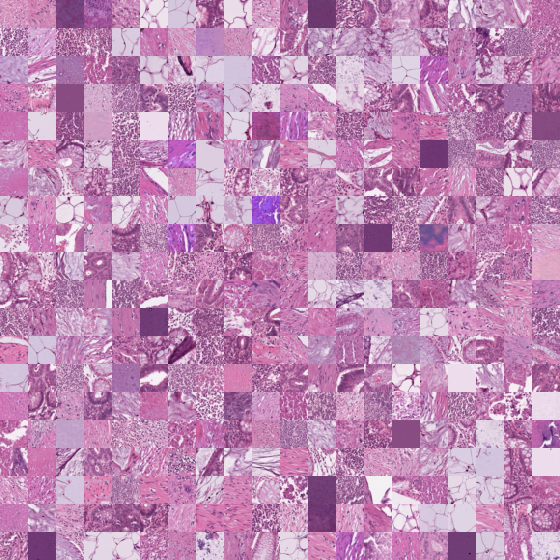

In [34]:
# montage

train_dataset.montage(length=20)

# Then, we define a basic VAE.

In [35]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = nn.functional.relu(self.fc1(x))
        mu = self.fc2(h)
        log_var = self.fc3(h)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        h = nn.functional.relu(self.fc4(z))
        out = torch.sigmoid(self.fc5(h))
        return out
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


# Next, we can start to train and evaluate!

In [36]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [37]:
for epoch in range(NUM_EPOCHS):
    for i, (x, _) in enumerate(train_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = nn.functional.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, NUM_EPOCHS, i+1, len(train_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(BATCH_SIZE, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/50], Step [10/704], Reconst Loss: 190613.6406, KL Div: 273.4797
Epoch[1/50], Step [20/704], Reconst Loss: 190950.9688, KL Div: 233.3409
Epoch[1/50], Step [30/704], Reconst Loss: 192320.6250, KL Div: 662.6686
Epoch[1/50], Step [40/704], Reconst Loss: 191300.4688, KL Div: 1619.9207
Epoch[1/50], Step [50/704], Reconst Loss: 192301.9844, KL Div: 1661.5551
Epoch[1/50], Step [60/704], Reconst Loss: 187155.8125, KL Div: 1662.2217
Epoch[1/50], Step [70/704], Reconst Loss: 187825.1094, KL Div: 2447.9919
Epoch[1/50], Step [80/704], Reconst Loss: 184737.2656, KL Div: 2617.6782
Epoch[1/50], Step [90/704], Reconst Loss: 182303.9375, KL Div: 2580.3030
Epoch[1/50], Step [100/704], Reconst Loss: 184629.9062, KL Div: 2874.4211
Epoch[1/50], Step [110/704], Reconst Loss: 185057.5469, KL Div: 2828.2324
Epoch[1/50], Step [120/704], Reconst Loss: 184219.0000, KL Div: 3429.9468
Epoch[1/50], Step [130/704], Reconst Loss: 186645.3281, KL Div: 3052.7847
Epoch[1/50], Step [140/704], Reconst Loss: 182646.

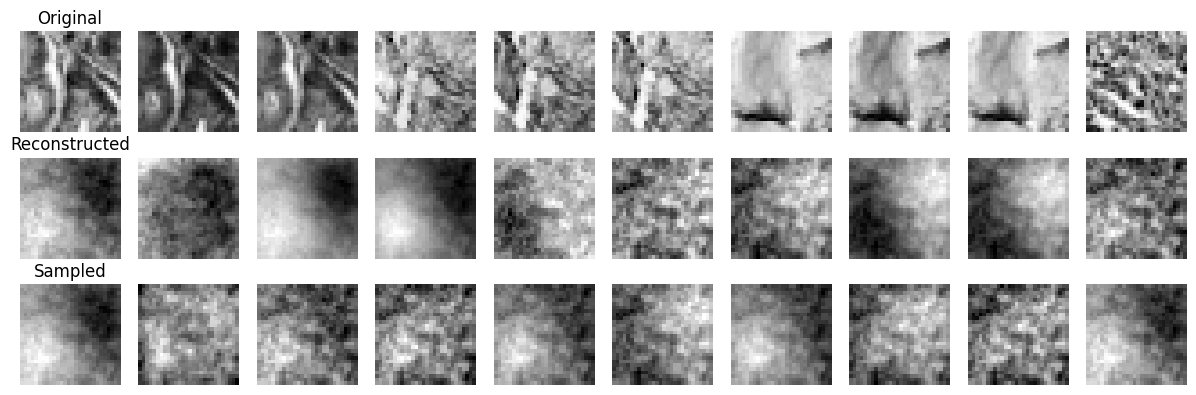

In [38]:
import matplotlib.pyplot as plt
import torch

model.eval()  # set to eval mode

# ======== RECONSTRUCTED IMAGES ========
x, _ = next(iter(test_loader))
x = x.to(device)
x_flat = x.view(-1, image_size)

with torch.no_grad():
    x_reconst, _, _ = model(x_flat)
    x = x.view(-1, 1, 28, 28).cpu()
    x_reconst = x_reconst.view(-1, 1, 28, 28).cpu()

# ======== SAMPLED IMAGES ========
with torch.no_grad():
    z = torch.randn(10, z_dim).to(device)
    samples = model.decode(z).view(-1, 1, 28, 28).cpu()

# ======== PLOT BOTH ========
fig, axes = plt.subplots(3, 10, figsize=(12, 4))

for i in range(10):
    axes[0, i].imshow(x[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_reconst[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].imshow(samples[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
axes[2, 0].set_title("Sampled")

plt.tight_layout()
plt.show()


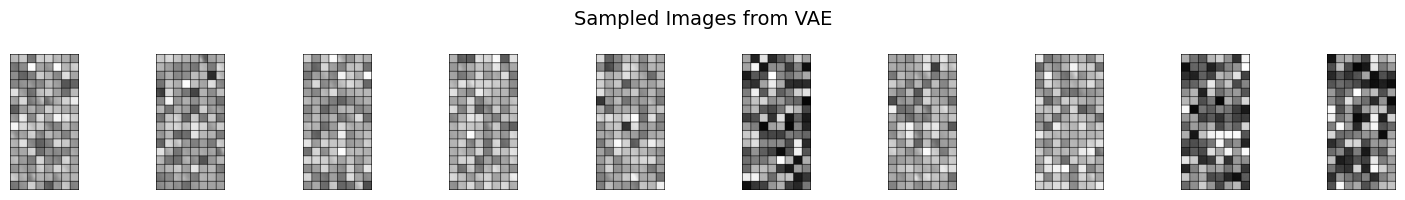

In [39]:
import matplotlib.pyplot as plt
from PIL import Image
import os

sample_dir = 'samples'  # or your actual folder
n = 10  # number of images to show

# List all sampled images and sort them
files = sorted([f for f in os.listdir(sample_dir) if f.startswith('sampled') and f.endswith('.png')])

# Pick last `n` images
selected_files = files[-n:]

# Plot them
fig, axes = plt.subplots(1, n, figsize=(n * 1.5, 2))
for i, file in enumerate(selected_files):
    img = Image.open(os.path.join(sample_dir, file)).convert('L')  # convert to grayscale
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.suptitle("Sampled Images from VAE", fontsize=14)
plt.tight_layout()
plt.show()
